In [1]:
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm

def f_model(x, a):
    a0, a1, a2 = a
    return (a1 * x + a0) / (x + a2)

# OLS
def fit_ols(x, y, a0):
    f = lambda a: np.sum((y - f_model(x, a))**2)
    res = minimize(f, a0, method="BFGS")
    return res.x

# LAR
def fit_lar(x, y, a0):
    f = lambda a: np.sum(np.abs(y - f_model(x, a)))
    res = minimize(f, a0, method="Powell")
    return res.x

# Minimax
def fit_minimax(x, y, a0):
    f = lambda a: np.max(np.abs(y - f_model(x, a)))
    res = minimize(f, a0, method="Powell")
    return res.x

true_a = np.array([0.0, 1.0, 1.0])
N = 1000
x = np.arange(0.1, 3.1, 0.1)
sigma = 0.05

methods = ["OLS", "LAR", "Minimax"]
results = {m: [] for m in methods}

def generate_noise(dist):
    if dist == "normal":
        return np.random.normal(0, sigma, size=len(x))
    elif dist == "uniform":
        return np.random.uniform(-np.sqrt(3)*sigma, np.sqrt(3)*sigma, len(x))
    elif dist == "laplace":
        lam = np.sqrt(2) / sigma
        return np.random.laplace(0, 1/lam, size=len(x))

for dist in ["normal", "uniform", "laplace"]:
    print(f"\n Distribution: {dist}")
    results = {m: [] for m in methods}

    for _ in tqdm(range(N)):
        eps = generate_noise(dist)
        y = f_model(x, true_a) + eps

        a_ols = fit_ols(x, y, true_a)
        a_lar = fit_lar(x, y, true_a)
        a_mm  = fit_minimax(x, y, true_a)

        results["OLS"].append(a_ols)
        results["LAR"].append(a_lar)
        results["Minimax"].append(a_mm)

    for m in methods:
        results[m] = np.array(results[m])

    print("\n Дисперсии оценок параметров (a0, a1, a2):")
    for m in methods:
        var = results[m].var(axis=0)
        print(f"{m:8s}: {var}")


 Distribution: normal


100%|██████████| 1000/1000 [00:31<00:00, 31.60it/s]



 Дисперсии оценок параметров (a0, a1, a2):
OLS     : [0.00427129 0.00659347 0.10066878]
LAR     : [0.00220889 0.00376614 0.04126396]
Minimax : [1.67453697e-03 3.51864934e-08 3.11752206e-06]

 Distribution: uniform


100%|██████████| 1000/1000 [00:23<00:00, 42.67it/s]



 Дисперсии оценок параметров (a0, a1, a2):
OLS     : [0.00455924 0.00746146 0.11394299]
LAR     : [0.00316603 0.00617314 0.06418244]
Minimax : [8.73663891e-05 1.54903261e-09 2.43235410e-13]

 Distribution: laplace


100%|██████████| 1000/1000 [00:23<00:00, 41.81it/s]


 Дисперсии оценок параметров (a0, a1, a2):
OLS     : [0.00433897 0.00642395 0.09973786]
LAR     : [0.00125654 0.00205815 0.02142213]
Minimax : [4.16096218e-03 1.41806092e-07 3.37691028e-04]



Plotting for distribution: normal


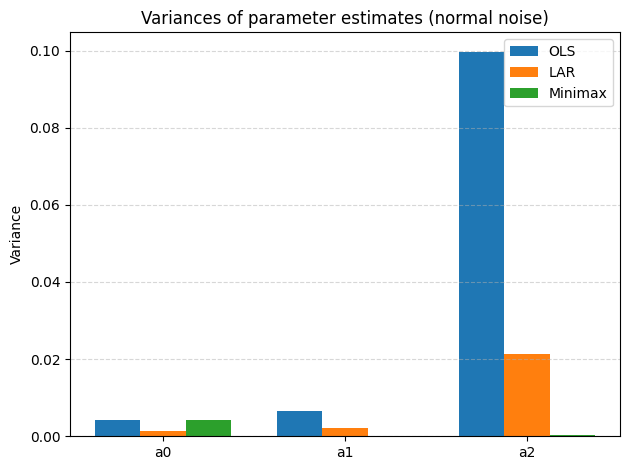


Plotting for distribution: uniform


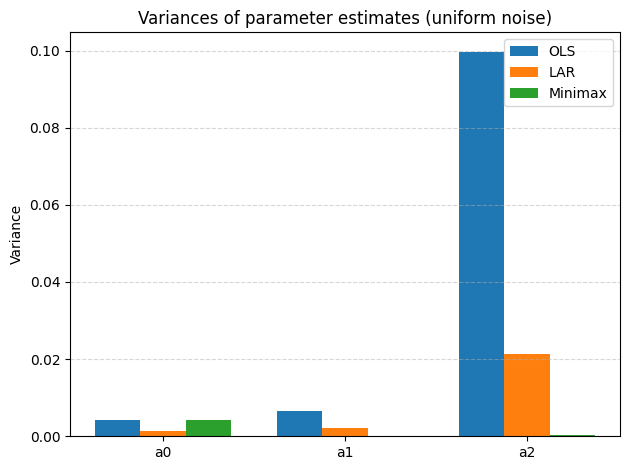


Plotting for distribution: laplace


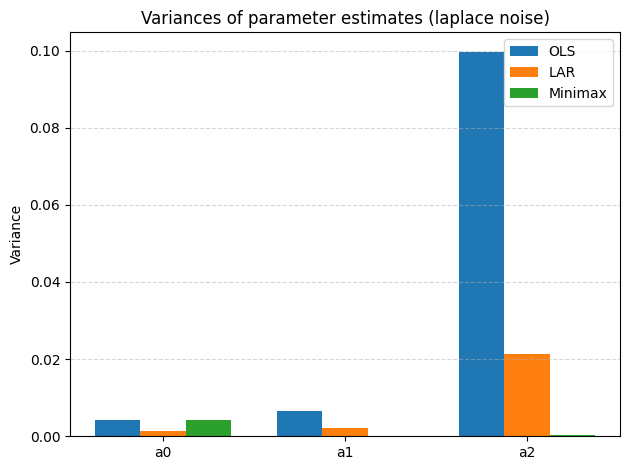

Histogram for parameter a1, noise = normal


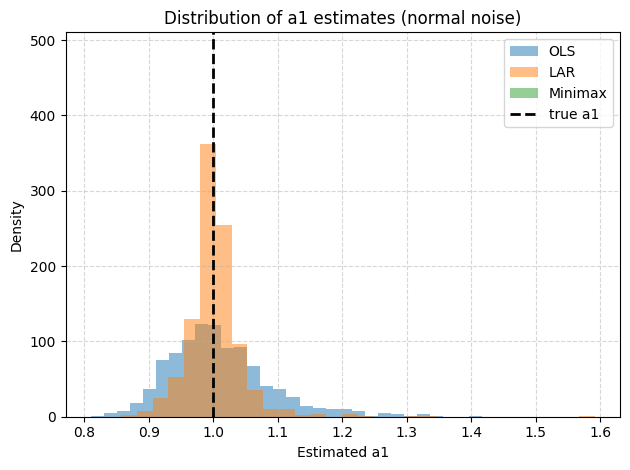

Histogram for parameter a1, noise = uniform


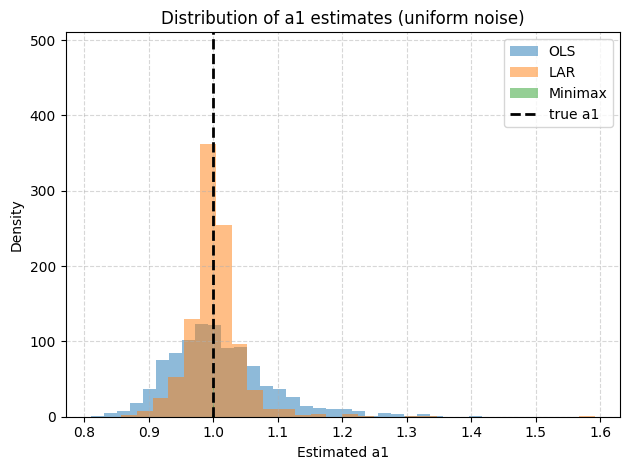

Histogram for parameter a1, noise = laplace


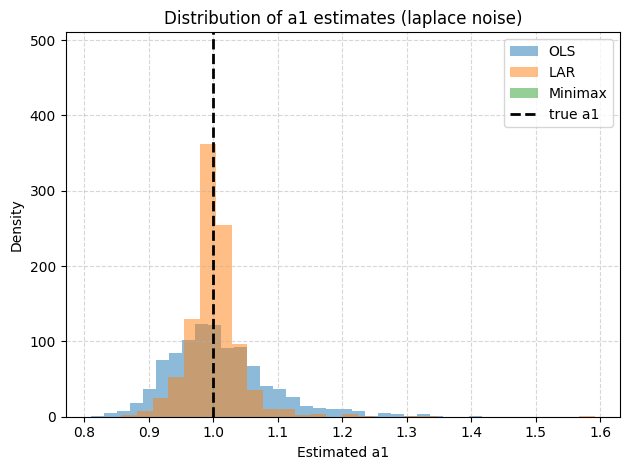

In [2]:
import matplotlib.pyplot as plt

params = ["a0", "a1", "a2"]
x_pos = np.arange(len(params))

for dist in ["normal", "uniform", "laplace"]:
    print(f"\nPlotting for distribution: {dist}")

    fig, ax = plt.subplots()
    width = 0.25

    for j, m in enumerate(methods):
        ax.bar(x_pos + j * width,
               results[m].var(axis=0),
               width,
               label=m)

    ax.set_xticks(x_pos + width)
    ax.set_xticklabels(params)
    ax.set_ylabel("Variance")
    ax.set_title(f"Variances of parameter estimates ({dist} noise)")
    ax.legend()
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

param_idx = 1

for dist in ["normal", "uniform", "laplace"]:
    print(f"Histogram for parameter a1, noise = {dist}")

    fig, ax = plt.subplots()
    for m in methods:
        ax.hist(results[m][:, param_idx],
                bins=30,
                alpha=0.5,
                label=m)

    ax.axvline(true_a[param_idx],
               color="k",
               linestyle="--",
               linewidth=2,
               label="true a1")

    ax.set_xlabel("Estimated a1")
    ax.set_ylabel("Density")
    ax.set_title(f"Distribution of a1 estimates ({dist} noise)")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

Домашнее задание

In [3]:
import scipy.stats as st
import pandas as pd

q_levels = [0.95, 0.99, 0.999]
outlier_vals = [st.norm.ppf(q) * sigma for q in q_levels]

def add_outliers(eps, k):
    idx = np.random.choice(len(eps), size=k, replace=False)
    eps2 = eps.copy()
    for j in range(k):
        eps2[idx[j]] += outlier_vals[j]
    return eps2, set(idx.tolist())

def reject_and_refit(x, y, fit_func, cutoff, max_iter=10):
    mask = np.ones(len(x), dtype=bool)
    for _ in range(max_iter):
        a_hat = fit_func(x[mask], y[mask], true_a)
        r = y[mask] - f_model(x[mask], a_hat)
        bad = np.abs(r) > cutoff
        if not np.any(bad):
            break
        keep_idx = np.where(mask)[0]
        mask[keep_idx[bad]] = False
    a_hat = fit_func(x[mask], y[mask], true_a)
    return mask, a_hat

def simulate_outlier_survival(fit_func, k, cutoff):
    survive = 0
    for _ in tqdm(range(N)):
        eps = generate_noise("normal")
        eps2, out_idx = add_outliers(eps, k)
        y = f_model(x, true_a) + eps2
        mask, _ = reject_and_refit(x, y, fit_func, cutoff)
        remaining = out_idx.intersection(set(np.where(mask)[0].tolist()))
        if len(remaining) > 0:
            survive += 1
    return survive / N

cutoff = outlier_vals[0]

rows = []
for k in [1, 2, 3]:
    p_ols = simulate_outlier_survival(fit_ols, k, cutoff)
    p_lar = simulate_outlier_survival(fit_lar, k, cutoff)
    rows.append({"k": k, "method": "OLS", "share_outlier_remains": p_ols})
    rows.append({"k": k, "method": "LAR", "share_outlier_remains": p_lar})

df_outliers = pd.DataFrame(rows)
print(df_outliers)

100%|██████████| 1000/1000 [00:37<00:00, 26.88it/s]

   k method  share_outlier_remains
0  1    OLS                  0.560
1  1    LAR                  0.528
2  2    OLS                  0.712
3  2    LAR                  0.650
4  3    OLS                  0.770
5  3    LAR                  0.690


При добавлении выбросов метод OLS чаще оставляет выбросы в данных, чем LAR, и эта разница увеличивается с ростом числа выбросов, что показывает более высокую устойчивость метода LAR к выбросам по сравнению с OLS.